In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, classification_report, confusion_matrix
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from imblearn.over_sampling import SMOTE
from collections import Counter
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN

#Data Preparation

In [ ]:
url = 'https://drive.google.com/uc?id=1P8xdYLFQLyLVNQvPWH-NAm2GmcZiL3tN'
df = pd.read_csv(url)

In [ ]:
df

,date,open,high,low,close,volume
0,2004-06-11 07:00:00,384.00000,384.30000,383.30000,383.80000,44
1,2004-06-11 08:00:00,383.80000,384.30000,383.10000,383.10000,41
2,2004-06-11 09:00:00,383.10000,384.10000,382.80000,383.10000,55
3,2004-06-11 10:00:00,383.00000,383.80000,383.00000,383.60000,33
4,2004-06-11 11:00:00,383.60000,383.80000,383.50000,383.60000,23
...,...,...,...,...,...,...
126418,2025-10-21 23:00:00,41.22565,41.27575,40.89645,40.92618,13633
126419,2025-10-22 00:00:00,40.92618,40.93345,40.03298,40.74598,37561
126420,2025-10-22 01:00:00,40.74598,41.20265,40.64009,40.86715,30710
126421,2025-10-22 02:00:00,40.86885,41.17525,40.86785,41.14685,17776


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126423 entries, 0 to 126422
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   date    126423 non-null  object 
 1   open    126423 non-null  float64
 2   high    126423 non-null  float64
 3   low     126423 non-null  float64
 4   close   126423 non-null  float64
 5   volume  126423 non-null  int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 5.8+ MB


In [ ]:
df.describe()

,open,high,low,close,volume
count,126423.000000,126423.000000,126423.000000,126423.000000,126423.000000
mean,1305.372068,1307.132139,1303.558487,1305.382302,3696.809022
std,589.198465,589.939154,588.428078,589.216974,4323.549640
min,26.236550,26.260050,26.143650,26.235550,1.000000
25%,932.050000,933.425000,930.500000,932.100000,813.000000
50%,1285.270000,1286.670000,1283.990000,1285.280000,2600.000000
75%,1713.465000,1715.885000,1711.110000,1713.510000,4917.000000
max,3843.360000,3844.910000,3842.410000,3843.800000,104200.000000


In [ ]:
df.duplicated(subset="date").sum()

np.int64(2122)

In [ ]:
df.isna().sum()

,0
date,0
open,0
high,0
low,0
close,0
volume,0


In [ ]:
# ubah kolom date jadi datetime
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# hitung median harga per tahun
df['year'] = df['date'].dt.year
df.groupby('year')['close'].median()

,close
year,
2004,407.500000
2005,434.100000
2006,610.200000
2007,670.500000
2008,884.300000
2009,947.560000
2010,1212.210000
2011,1546.535000
2012,1663.220000


#Data Preprocessing

In [ ]:
df.drop_duplicates(subset="date", inplace=True)

In [ ]:
df.duplicated(subset="date").sum()

np.int64(0)

In [ ]:
mask = (df['year'] == 2025) & (df['close'] < 100)
df.loc[mask, ['open', 'high', 'low', 'close']] *= 100

In [ ]:
df = df.drop(columns=['year'])

Outlier di close: 4465


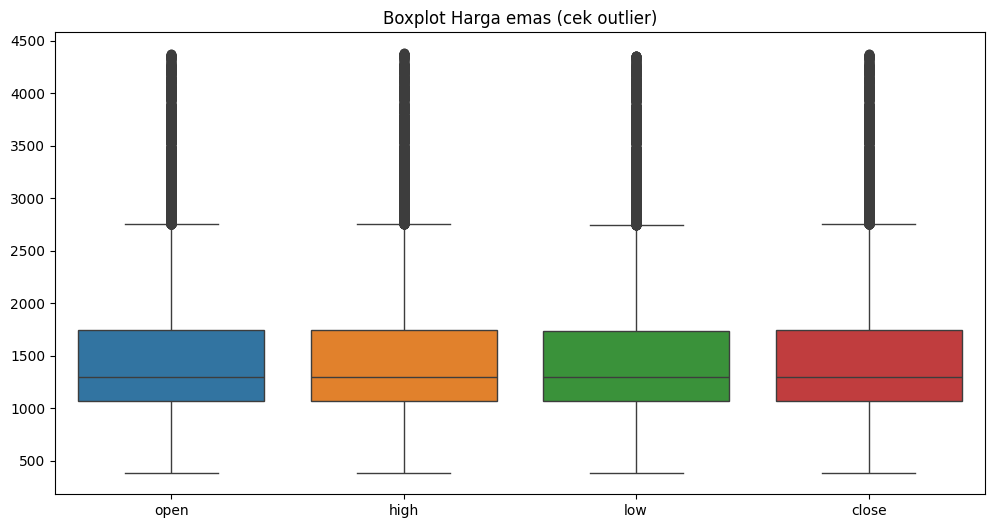

In [ ]:
def detect_outliers_iqr(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[col] < lower_bound) | (df[col] > upper_bound)]

outliers_close = detect_outliers_iqr(df, 'close')
print("Outlier di close:", len(outliers_close))


plt.figure(figsize=(12,6))
sns.boxplot(data=df[['open','high','low','close']])
plt.title("Boxplot Harga emas (cek outlier)")
plt.show()

# Visualization

In [ ]:
df = df.set_index('date')

monthly = df.resample('M').agg({
    'open': 'first',
    'high': 'max',
    'low': 'min',
    'close': 'last'
}).reset_index()

/tmp/ipython-input-405379971.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly = df.resample('M').agg({


In [ ]:
monthly

,date,open,high,low,close
0,2004-06-30,384.000,404.600,381.100,393.300
1,2004-07-31,391.600,408.600,384.500,390.500
2,2004-08-31,390.300,413.800,388.100,409.300
3,2004-09-30,409.600,418.600,394.300,417.800
4,2004-10-31,417.800,430.200,409.100,428.100
...,...,...,...,...,...
252,2025-06-30,3298.375,3451.085,3244.925,3312.298
253,2025-07-31,3312.249,3438.655,3267.955,3288.355
254,2025-08-31,3288.375,3453.565,3281.435,3447.685
255,2025-09-30,3447.685,3871.505,3436.548,3862.765


In [ ]:
monthly['Year'] = monthly['date'].dt.year
monthly['Month'] = monthly['date'].dt.month_name()
monthly['Month_Num'] = monthly['date'].dt.month

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


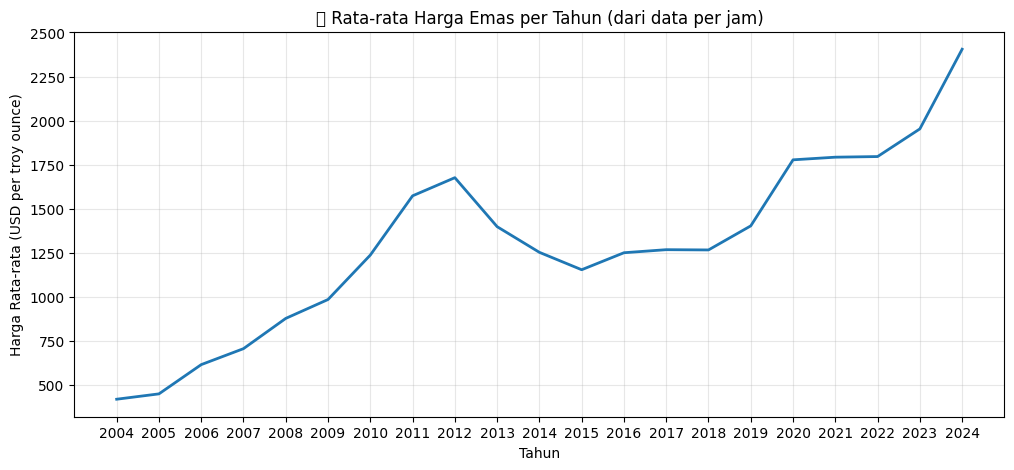

In [ ]:
yearly_avg = monthly.groupby('Year')['close'].mean().reset_index()
yearly_avg = yearly_avg[yearly_avg['Year'] < 2025]

plt.figure(figsize=(12,5))
sns.lineplot(data=yearly_avg, x='Year', y='close', linewidth=2)
plt.title("📈 Rata-rata Harga Emas per Tahun (dari data per jam)")
plt.xticks(sorted(yearly_avg['Year'].unique().astype(int)))
plt.xlabel("Tahun")
plt.ylabel("Harga Rata-rata (USD per troy ounce)")
plt.grid(True, alpha=0.3)
plt.show()

/tmp/ipython-input-4259592347.py:22: UserWarning: Glyph 128197 (\N{CALENDAR}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128197 (\N{CALENDAR}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


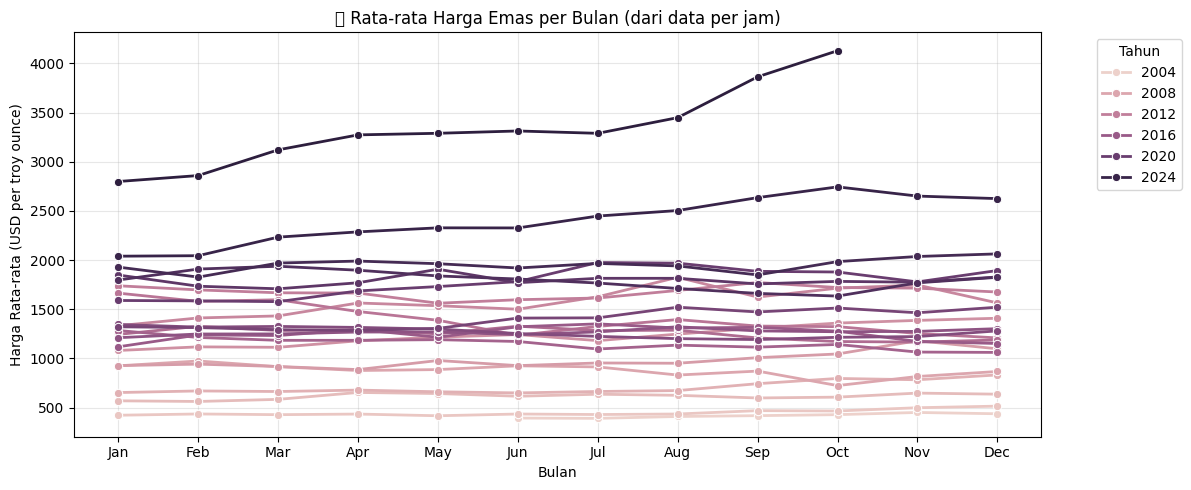

In [ ]:
monthly_avg = monthly.groupby(['Year', 'Month_Num', 'Month'])['close'].mean().reset_index()

monthly_avg['Month_Num'] = monthly_avg['Month_Num']

plt.figure(figsize=(12,5))
sns.lineplot(data=monthly_avg, x='Month_Num', y='close', hue='Year', linewidth=2, marker='o')

plt.xticks(ticks=range(1,13), labels=[
    'Jan','Feb','Mar','Apr','May','Jun',
    'Jul','Aug','Sep','Oct','Nov','Dec'
])

plt.title("📅 Rata-rata Harga Emas per Bulan (dari data per jam)")
plt.xlabel("Bulan")
plt.ylabel("Harga Rata-rata (USD per troy ounce)")
plt.grid(True, alpha=0.3)
plt.legend(title='Tahun', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


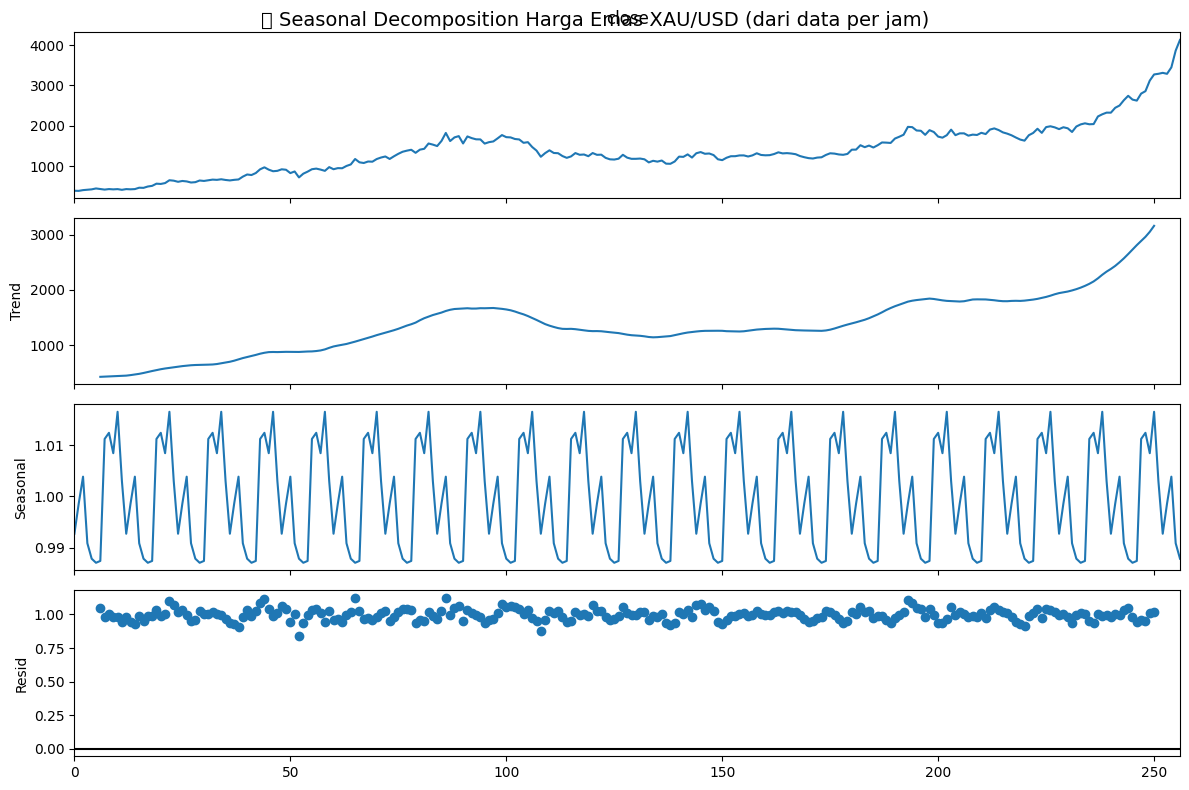

In [ ]:
monthly_data = monthly.dropna(subset=['close'])

result = seasonal_decompose(monthly_data['close'], model='multiplicative', period=12)

plt.rcParams.update({'figure.figsize': (12,8)})
result.plot()
plt.suptitle("🔍 Seasonal Decomposition Harga Emas XAU/USD (dari data per jam)", fontsize=14)
plt.show()

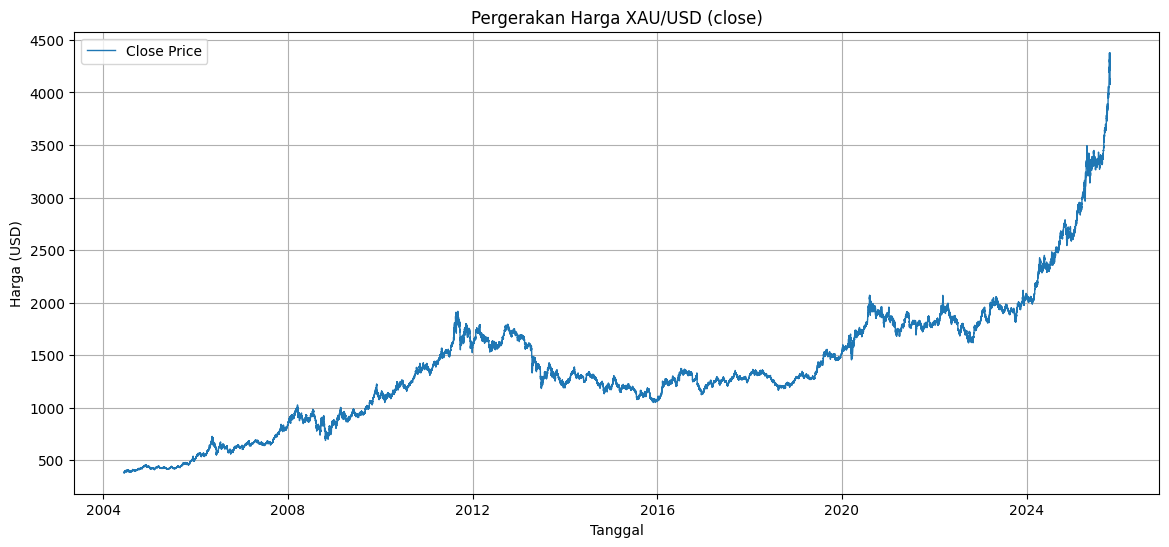

In [ ]:
plt.figure(figsize=(14, 6))
plt.plot(df['close'], label='Close Price', linewidth=1)
plt.title("Pergerakan Harga XAU/USD (close)")
plt.xlabel("Tanggal")
plt.ylabel("Harga (USD)")
plt.legend()
plt.grid(True)
plt.show()

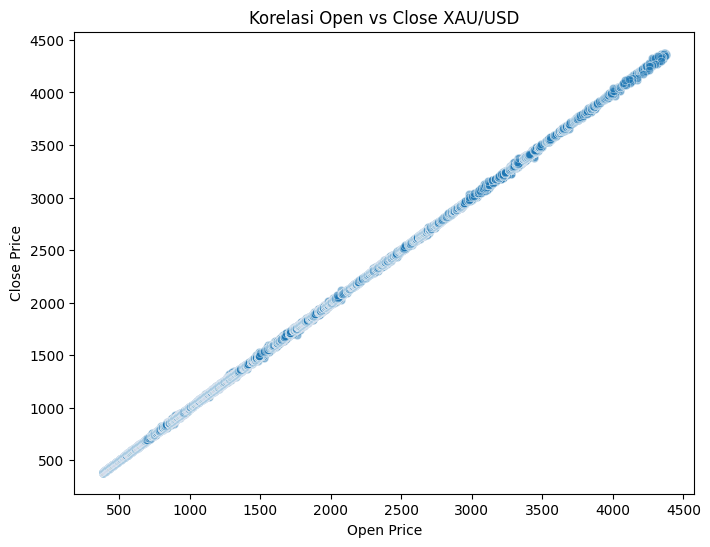

In [ ]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='open', y='close', data=df, alpha=0.5)
plt.title("Korelasi Open vs Close XAU/USD")
plt.xlabel("Open Price")
plt.ylabel("Close Price")
plt.show()

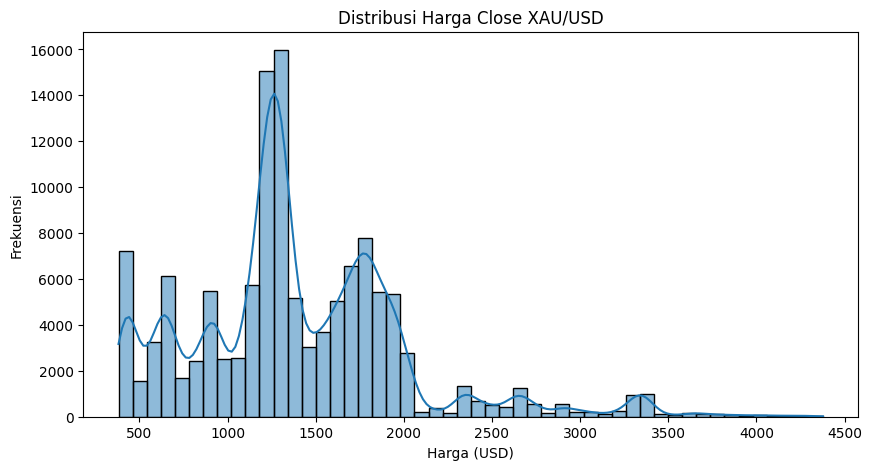

In [ ]:
plt.figure(figsize=(10, 5))
sns.histplot(df['close'], bins=50, kde=True)
plt.title("Distribusi Harga Close XAU/USD")
plt.xlabel("Harga (USD)")
plt.ylabel("Frekuensi")
plt.show()

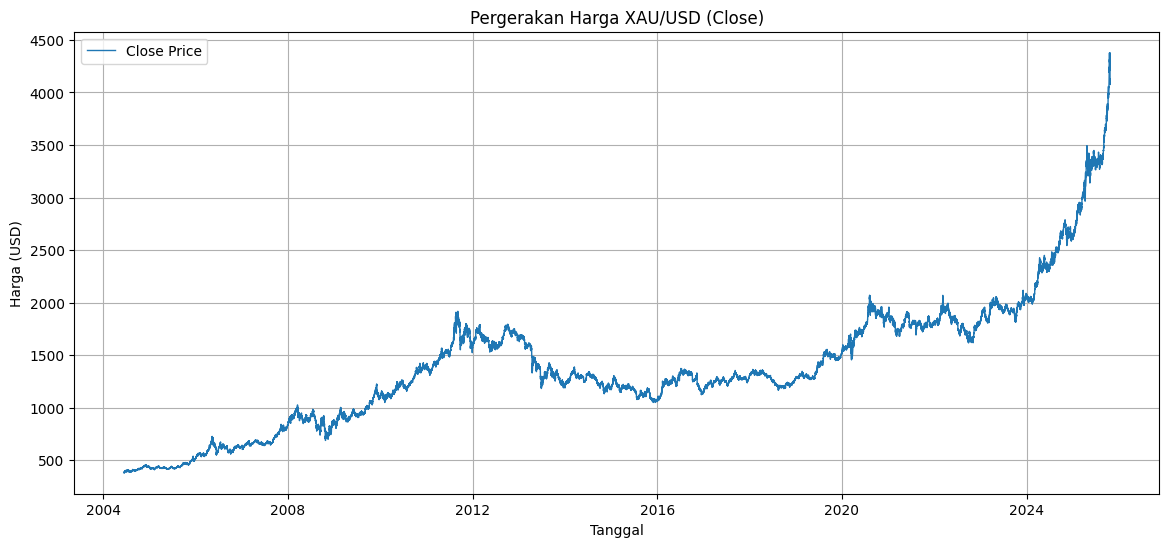

In [ ]:
plt.figure(figsize=(14, 6))
plt.plot(df['close'], label='Close Price', linewidth=1)
plt.title("Pergerakan Harga XAU/USD (Close)")
plt.xlabel("Tanggal")
plt.ylabel("Harga (USD)")
plt.legend()
plt.grid(True)
plt.show()

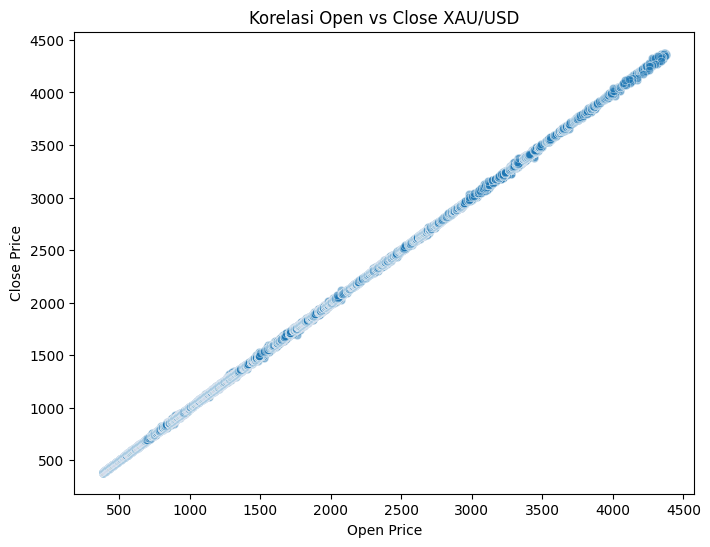

In [ ]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='open', y='close', data=df, alpha=0.5)
plt.title("Korelasi Open vs Close XAU/USD")
plt.xlabel("Open Price")
plt.ylabel("Close Price")
plt.show()

In [ ]:
df

,open,high,low,close,volume
date,,,,,
2004-06-11 07:00:00,384.000,384.300,383.300,383.800,44
2004-06-11 08:00:00,383.800,384.300,383.100,383.100,41
2004-06-11 09:00:00,383.100,384.100,382.800,383.100,55
2004-06-11 10:00:00,383.000,383.800,383.000,383.600,33
2004-06-11 11:00:00,383.600,383.800,383.500,383.600,23
...,...,...,...,...,...
2025-10-21 23:00:00,4122.565,4127.575,4089.645,4092.618,13633
2025-10-22 00:00:00,4092.618,4093.345,4003.298,4074.598,37561
2025-10-22 01:00:00,4074.598,4120.265,4064.009,4086.715,30710


In [ ]:
monthly['daily_return'] = monthly['close'].pct_change() * 100

monthly['daily_range'] = monthly['high'] - monthly['low']

In [ ]:
print(monthly.columns)

Index(['date', 'open', 'high', 'low', 'close', 'Year', 'Month', 'Month_Num',
       'daily_return', 'daily_range'],
      dtype='object')


In [ ]:
monthly

,date,open,high,low,close,Year,Month,Month_Num,daily_return,daily_range
0,2004-06-30,384.000,404.600,381.100,393.300,2004,June,6,NaN,23.500
1,2004-07-31,391.600,408.600,384.500,390.500,2004,July,7,-0.711925,24.100
2,2004-08-31,390.300,413.800,388.100,409.300,2004,August,8,4.814341,25.700
3,2004-09-30,409.600,418.600,394.300,417.800,2004,September,9,2.076716,24.300
4,2004-10-31,417.800,430.200,409.100,428.100,2004,October,10,2.465294,21.100
...,...,...,...,...,...,...,...,...,...,...
252,2025-06-30,3298.375,3451.085,3244.925,3312.298,2025,June,6,0.716935,206.160
253,2025-07-31,3312.249,3438.655,3267.955,3288.355,2025,July,7,-0.722852,170.700
254,2025-08-31,3288.375,3453.565,3281.435,3447.685,2025,August,8,4.845280,172.130
255,2025-09-30,3447.685,3871.505,3436.548,3862.765,2025,September,9,12.039383,434.957


/tmp/ipython-input-423886155.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=vol_yearly, x='year', y='volatility', palette='viridis')


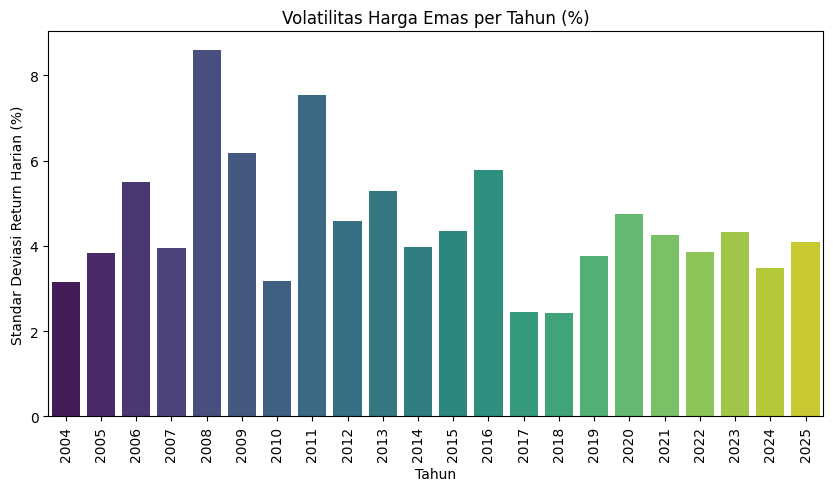

📈 Tahun dengan volatilitas tertinggi: 2008
🔹 Nilai volatilitas: 8.6 %


In [ ]:
vol_yearly = monthly.groupby('Year')['daily_return'].std().reset_index()
vol_yearly.columns = ['year', 'volatility']

plt.figure(figsize=(10,5))
sns.barplot(data=vol_yearly, x='year', y='volatility', palette='viridis')
plt.title('Volatilitas Harga Emas per Tahun (%)')
plt.ylabel('Standar Deviasi Return Harian (%)')
plt.xlabel('Tahun')
plt.xticks(rotation=90)
plt.show()

max_vol_year = vol_yearly.loc[vol_yearly['volatility'].idxmax()]
print("📈 Tahun dengan volatilitas tertinggi:", int(max_vol_year['year']))
print("🔹 Nilai volatilitas:", round(max_vol_year['volatility'], 2), "%")

In [ ]:
max_year = yearly_avg.loc[yearly_avg['close'].idxmax()]
min_year = yearly_avg.loc[yearly_avg['close'].idxmin()]

In [ ]:
print("=== TAHUN HARGA EMAS TERTINGGI ===")
print(f"Tahun : {int(max_year['Year'])}")
print(f"Harga rata-rata : {max_year['close']:.2f}")

=== TAHUN HARGA EMAS TERTINGGI ===
Tahun : 2024
Harga rata-rata : 2405.02


In [ ]:
print("\n=== TAHUN HARGA EMAS TERENDAH ===")
print(f"Tahun : {int(min_year['Year'])}")
print(f"Harga rata-rata : {min_year['close']:.2f}")


=== TAHUN HARGA EMAS TERENDAH ===
Tahun : 2004
Harga rata-rata : 418.04


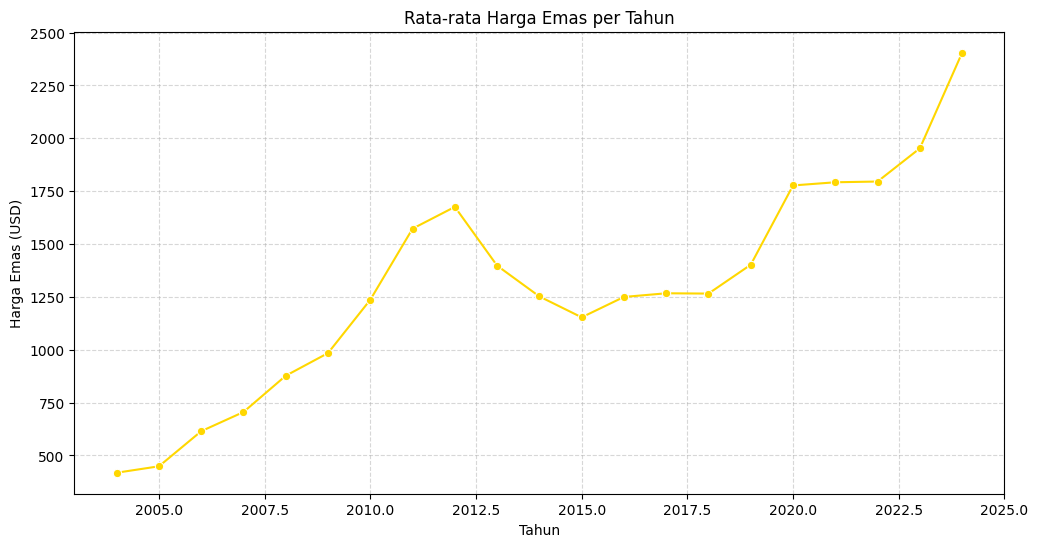

In [ ]:
plt.figure(figsize=(12,6))
sns.lineplot(data=yearly_avg, x='Year', y='close', marker='o', color='gold')
plt.title('Rata-rata Harga Emas per Tahun')
plt.xlabel('Tahun')
plt.ylabel('Harga Emas (USD)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# Classification Modelling

In [ ]:
df['return'] = df['close'].pct_change().shift(-1)

buy_threshold = 0.0015
sell_threshold = -0.0015

def label_signal(r):
    if r > buy_threshold:
        return "buy"
    elif r < sell_threshold:
        return "sell"
    else:
        return "hold"

df['signal'] = df['return'].apply(label_signal)

In [ ]:
df['return_1h'] = df['close'].pct_change()
df['ma_5'] = df['close'].rolling(5).mean()
df['ma_20'] = df['close'].rolling(20).mean()
df['ma_ratio'] = df['ma_5'] / df['ma_20']

def rsi(series, period=14):
    delta = series.diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.rolling(period).mean()
    avg_loss = loss.rolling(period).mean()
    rs = avg_gain / avg_loss
    return 100 - (100 / (1 + rs))

df['rsi_14'] = rsi(df['close'])

df['volatility'] = (df['high'] - df['low']) / df['open']

df['volume_change'] = df['volume'].pct_change()


Text(0.5, 1.0, 'Correlation Matrix Fitur XAU/USD')

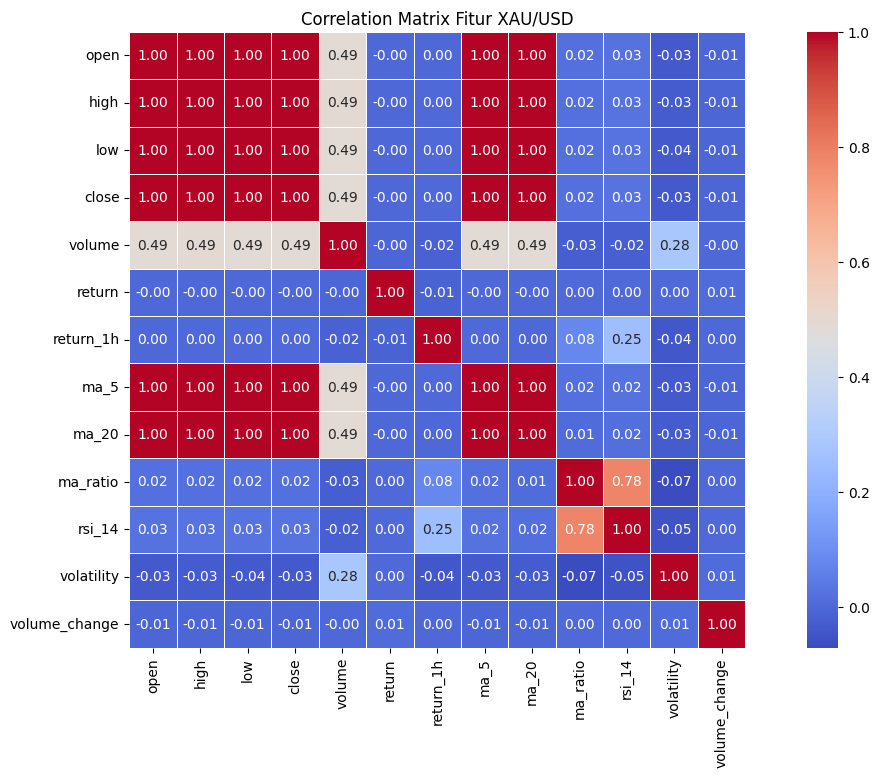

In [ ]:
plt.figure(figsize=(16,8))
sns.heatmap(
    df.drop(['signal', 'cluster'], axis=1).corr(),
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
    cbar=True,
    square=True,
    linewidths=0.5
)
plt.title("Correlation Matrix Fitur XAU/USD")

In [ ]:
features = ['return_1h', 'ma_ratio', 'rsi_14', 'volatility', 'volume_change']
df = df.dropna()

X = df[features]
y = df['signal']

In [ ]:
Counter(y)

Counter({'hold': 87049, 'buy': 19131, 'sell': 18101})

In [ ]:
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)

In [ ]:
X_res

,return_1h,ma_ratio,rsi_14,volatility,volume_change
0,-0.000784,0.998279,40.740741,0.003921,-0.250000
1,0.000000,0.998109,31.914894,0.001830,0.703704
2,0.000000,0.997848,33.333333,0.001309,-0.152174
3,0.000523,0.997769,23.076923,0.001831,0.461538
4,0.000261,0.997899,27.027027,0.001308,-0.333333
...,...,...,...,...,...
261142,0.007423,1.001677,77.885165,0.012271,4.834461
261143,0.001031,0.999591,52.143188,0.001730,-0.016761
261144,-0.000876,0.997103,34.742700,0.002160,-0.046305
261145,-0.000151,1.007087,86.390395,0.002845,0.088227


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X_res, y_res, test_size=0.2, random_state=42, stratify=y_res
)

In [ ]:
Counter(y_test)

Counter({'hold': 17410, 'buy': 17410, 'sell': 17410})

In [ ]:
model = RandomForestClassifier(n_estimators=200, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         buy       0.63      0.64      0.64     17410
        hold       0.63      0.62      0.62     17410
        sell       0.64      0.64      0.64     17410

    accuracy                           0.63     52230
   macro avg       0.63      0.63      0.63     52230
weighted avg       0.63      0.63      0.63     52230



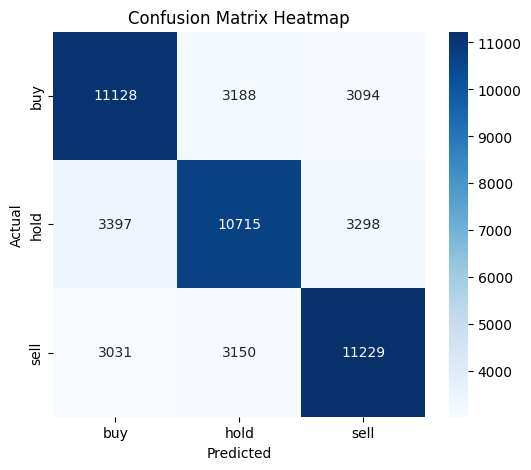

In [ ]:
cm = confusion_matrix(y_test, y_pred, labels=['buy', 'hold', 'sell'])

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['buy', 'hold', 'sell'], yticklabels=['buy', 'hold', 'sell'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Heatmap')
plt.show()

In [ ]:
proba = model.predict_proba(X_test)

classes = model.classes_

threshold = 0.5
y_pred_defensive = []

for p in proba:
    max_prob = np.max(p)
    pred_class = classes[np.argmax(p)]

    if max_prob < threshold:
        y_pred_defensive.append("hold")
    else:
        y_pred_defensive.append(pred_class)


In [ ]:
print(classification_report(y_test, y_pred_defensive))

              precision    recall  f1-score   support

         buy       0.79      0.43      0.56     17410
        hold       0.46      0.88      0.61     17410
        sell       0.78      0.44      0.56     17410

    accuracy                           0.58     52230
   macro avg       0.68      0.58      0.58     52230
weighted avg       0.68      0.58      0.58     52230



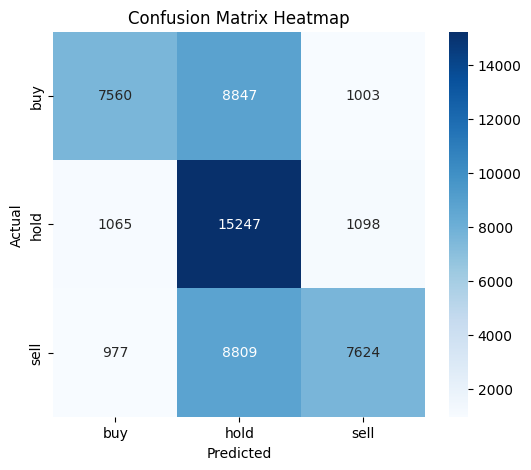

In [ ]:
cm = confusion_matrix(y_test, y_pred_defensive, labels=['buy', 'hold', 'sell'])

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['buy', 'hold', 'sell'], yticklabels=['buy', 'hold', 'sell'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Heatmap')
plt.show()

In [ ]:
le = LabelEncoder()

y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

In [ ]:
model = XGBClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=6,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

model.fit(X_train, y_train_encoded)


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [15:29:39] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, ...)

In [ ]:
y_pred_encoded = model.predict(X_test)
y_pred = le.inverse_transform(y_pred_encoded)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         buy       0.50      0.44      0.47     17410
        hold       0.57      0.62      0.60     17410
        sell       0.49      0.50      0.49     17410

    accuracy                           0.52     52230
   macro avg       0.52      0.52      0.52     52230
weighted avg       0.52      0.52      0.52     52230



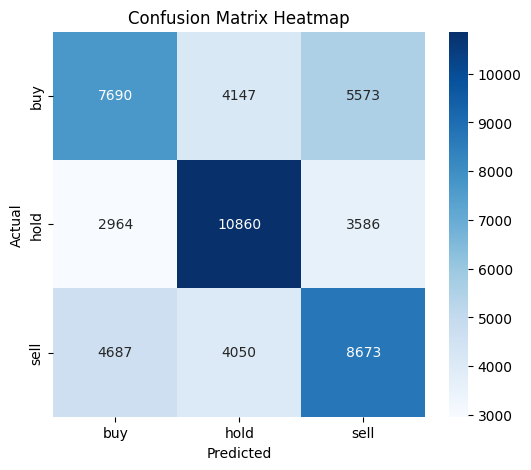

In [ ]:
cm = confusion_matrix(y_test, y_pred, labels=['buy', 'hold', 'sell'])

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['buy', 'hold', 'sell'], yticklabels=['buy', 'hold', 'sell'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Heatmap')
plt.show()

In [ ]:
label_map = {0: "buy", 1: "sell", 2: "hold"}

y_pred_defensive = []

for p in proba:
    max_prob = np.max(p)
    pred_class = classes[np.argmax(p)]

    if max_prob < threshold:
        y_pred_defensive.append("hold")
    else:
        y_pred_defensive.append(pred_class)

print(classification_report(y_test, y_pred_defensive))


              precision    recall  f1-score   support

         buy       0.79      0.43      0.56     17410
        hold       0.46      0.88      0.61     17410
        sell       0.78      0.44      0.56     17410

    accuracy                           0.58     52230
   macro avg       0.68      0.58      0.58     52230
weighted avg       0.68      0.58      0.58     52230



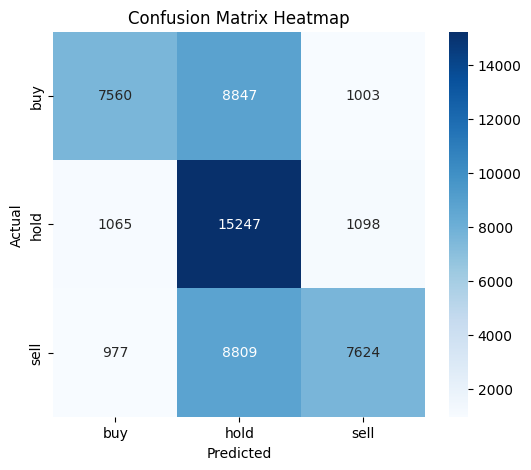

In [ ]:
cm = confusion_matrix(y_test, y_pred_defensive, labels=['buy', 'hold', 'sell'])

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['buy', 'hold', 'sell'], yticklabels=['buy', 'hold', 'sell'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Heatmap')
plt.show()

# Regression Model

In [ ]:
y_reg = df['return']

X_train, X_test, y_train, y_test = train_test_split(X, y_reg, test_size=0.2, shuffle=False)

In [ ]:
xgb_model = XGBRegressor(
    n_estimators=500,
    learning_rate=0.03,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)

In [ ]:
print(y_test.min(), y_test.max())
print(y_test[:10])

-0.029089582087440724 0.022156466164324762
99443   -0.000759
99444   -0.000383
99445    0.000851
99446   -0.000599
99447   -0.000360
99448   -0.000411
99449    0.000411
99450    0.000605
99451   -0.000183
99452    0.000839
Name: return, dtype: float64


In [ ]:
split = int(len(df) * 0.8)
time_steps = 30

In [ ]:
initial_price = df['close'].iloc[split + time_steps - 1]

y_test_price = [initial_price]
for r in y_test:
    y_test_price.append(y_test_price[-1] * (1 + r))
y_test_price = np.array(y_test_price[1:])

y_pred_price = [initial_price]
for r in y_pred:
    y_pred_price.append(y_pred_price[-1] * (1 + r))
y_pred_price = np.array(y_pred_price[1:])

In [ ]:
print(y_test_price.min(), y_test_price.max())
print(y_test_price[:10])

1619.0058425517568 4384.0919711780525
[1753.99810307 1753.32714747 1754.8192726  1753.76777503 1753.13687648
 1752.41584957 1753.13687648 1754.19838832 1753.87793192 1755.35002853]


In [ ]:
print("MAE:", mean_absolute_error(y_test_price, y_pred_price))
print("RMSE:", np.sqrt(mean_squared_error(y_test_price, y_pred_price)))
print("R²:", r2_score(y_test_price, y_pred_price))

MAE: 229.05948818890036
RMSE: 302.54401307816653
R²: 0.7238210304371873


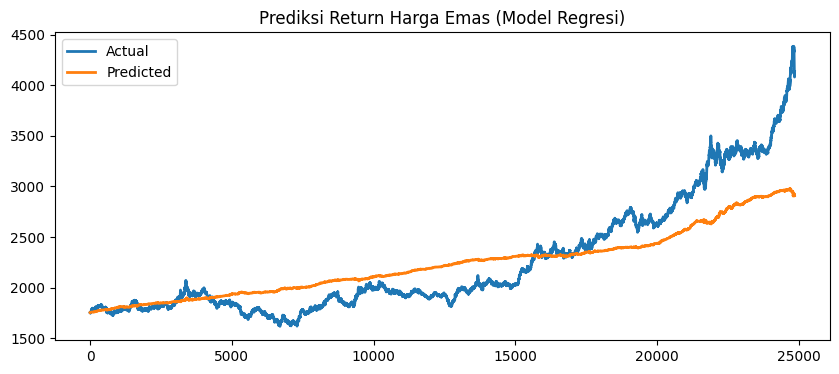

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(y_test_price, label="Actual", linewidth=2)
plt.plot(y_pred_price, label="Predicted", linewidth=2)
plt.title("Prediksi Return Harga Emas (Model Regresi)")
plt.legend()
plt.show()

In [ ]:
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

y_train_scaled = scaler_y.fit_transform(y_train.to_numpy().reshape(-1,1))
y_test_scaled = scaler_y.transform(y_test.to_numpy().reshape(-1,1))

In [ ]:
X_train_lstm = np.expand_dims(X_train_scaled, axis=1)
X_test_lstm = np.expand_dims(X_test_scaled, axis=1)

In [ ]:
lstm_model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
    Dropout(0.2),
    LSTM(32, return_sequences=False),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1)
])

lstm_model.compile(optimizer='adam', loss='mse')

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

In [ ]:
history = lstm_model.fit(
    X_train_lstm, y_train_scaled,
    epochs=10,
    batch_size=16,
    validation_split=0.1,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

Epoch 1/10
5593/5593 ━━━━━━━━━━━━━━━━━━━━ 56s 9ms/step - loss: 1.0040 - val_loss: 0.9936 - learning_rate: 0.0010
Epoch 2/10
5593/5593 ━━━━━━━━━━━━━━━━━━━━ 36s 6ms/step - loss: 1.0119 - val_loss: 0.9932 - learning_rate: 0.0010
Epoch 3/10
5593/5593 ━━━━━━━━━━━━━━━━━━━━ 37s 7ms/step - loss: 1.0061 - val_loss: 0.9925 - learning_rate: 0.0010
Epoch 4/10
5593/5593 ━━━━━━━━━━━━━━━━━━━━ 37s 7ms/step - loss: 1.0015 - val_loss: 0.9931 - learning_rate: 0.0010
Epoch 5/10
5593/5593 ━━━━━━━━━━━━━━━━━━━━ 38s 7ms/step - loss: 0.9897 - val_loss: 0.9932 - learning_rate: 0.0010
Epoch 6/10
5593/5593 ━━━━━━━━━━━━━━━━━━━━ 37s 7ms/step - loss: 0.9923 - val_loss: 0.9928 - learning_rate: 0.0010


In [ ]:
y_pred_scaled = lstm_model.predict(X_test_lstm)
y_pred = scaler_y.inverse_transform(y_pred_scaled)

777/777 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


In [ ]:
initial_price = df['close'].iloc[split + time_steps - 1]

y_test_price = [initial_price]
for r in y_test:
    y_test_price.append(y_test_price[-1] * (1 + r))
y_test_price = np.array(y_test_price[1:])

y_pred_price = [initial_price]
for r in y_pred:
    y_pred_price.append(y_pred_price[-1] * (1 + r))
y_pred_price = np.array(y_pred_price[1:])


In [ ]:
print(y_test_price.min(), y_test_price.max())
print(y_test_price[:10])

1619.0058425517568 4384.0919711780525
[1753.99810307 1753.32714747 1754.8192726  1753.76777503 1753.13687648
 1752.41584957 1753.13687648 1754.19838832 1753.87793192 1755.35002853]


In [ ]:
mae = mean_absolute_error(y_test_price, y_pred_price)
rmse = np.sqrt(mean_squared_error(y_test_price, y_pred_price))
r2 = r2_score(y_test_price, y_pred_price)

print("=== LSTM Regression Performance ===")
print(f"MAE  : {mae:.6f}")
print(f"RMSE : {rmse:.6f}")
print(f"R²   : {r2:.6f}")

=== LSTM Regression Performance ===
MAE  : 263.385534
RMSE : 405.579049
R²   : 0.503677


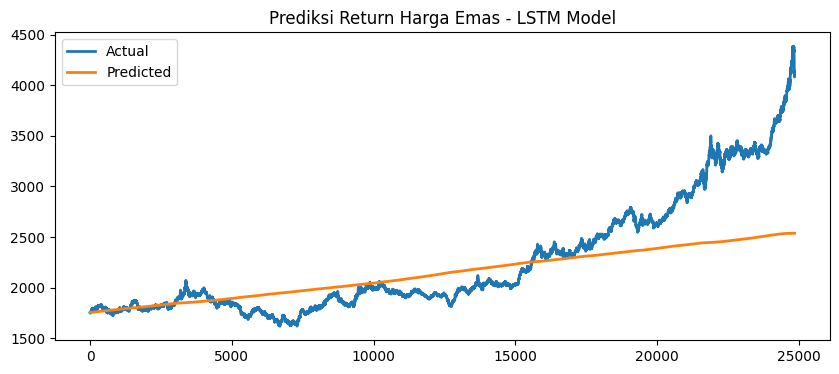

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(y_test_price, label="Actual", linewidth=2)
plt.plot(y_pred_price, label="Predicted", linewidth=2)
plt.title("Prediksi Return Harga Emas - LSTM Model")
plt.legend()
plt.show()

# Clustering Model

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
kmeans = KMeans(n_clusters=3, random_state=42)
df['cluster'] = kmeans.fit_predict(X_scaled)

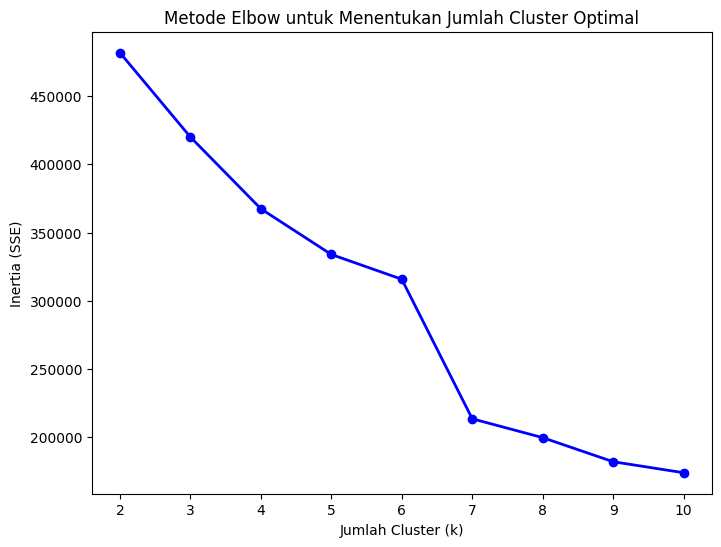

In [ ]:
inertias = []
K = range(2, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(8,6))
plt.plot(K, inertias, 'bo-', linewidth=2)
plt.xlabel('Jumlah Cluster (k)')
plt.ylabel('Inertia (SSE)')
plt.title('Metode Elbow untuk Menentukan Jumlah Cluster Optimal')
plt.show()

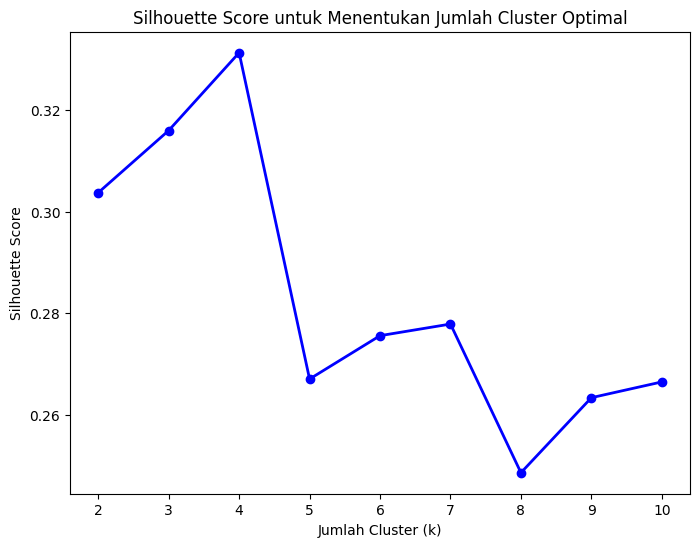

In [ ]:
silhouette_scores = []

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    silhouette_scores.append(score)

plt.figure(figsize=(8,6))
plt.plot(range(2, 11), silhouette_scores, 'bo-', linewidth=2)
plt.xlabel('Jumlah Cluster (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score untuk Menentukan Jumlah Cluster Optimal')
plt.show()

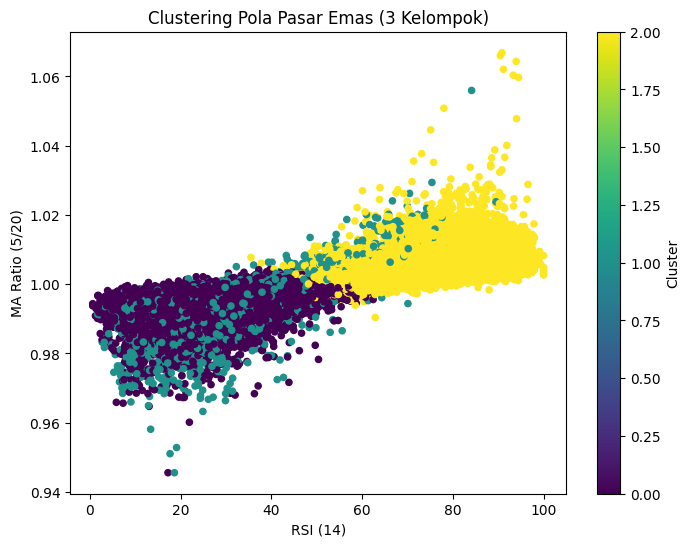

In [ ]:
plt.figure(figsize=(8,6))
plt.scatter(df['rsi_14'], df['ma_ratio'], c=df['cluster'], cmap='viridis', s=20)
plt.xlabel("RSI (14)")
plt.ylabel("MA Ratio (5/20)")
plt.title("Clustering Pola Pasar Emas (3 Kelompok)")
plt.colorbar(label='Cluster')
plt.show()

In [ ]:
cluster_summary = df.groupby('cluster')[['return_1h','ma_ratio','rsi_14','volatility','volume_change']].mean()
print(cluster_summary)

         return_1h  ma_ratio     rsi_14  volatility  volume_change
cluster                                                           
0         0.000020  0.997679  38.528668    0.002322       0.172943
1        -0.004937  0.997092  35.653549    0.008364       3.908426
2         0.000582  1.003132  66.419457    0.002685       0.259196


In [ ]:
dbscan = DBSCAN(eps=0.5, min_samples=5)
df['cluster'] = dbscan.fit_predict(X_scaled)

In [ ]:
n_clusters = len(set(df['cluster'])) - (1 if -1 in df['cluster'] else 0)
n_noise = list(df['cluster']).count(-1)
print(f"Jumlah cluster: {n_clusters}")
print(f"Jumlah noise (outlier): {n_noise}")

Jumlah cluster: 26
Jumlah noise (outlier): 2375


In [ ]:
if n_clusters > 1:
    score = silhouette_score(X_scaled, df['cluster'])
    print(f"Silhouette Score: {score:.3f}")
else:
    print("Silhouette Score tidak bisa dihitung (hanya 1 cluster terbentuk).")

Silhouette Score: 0.024


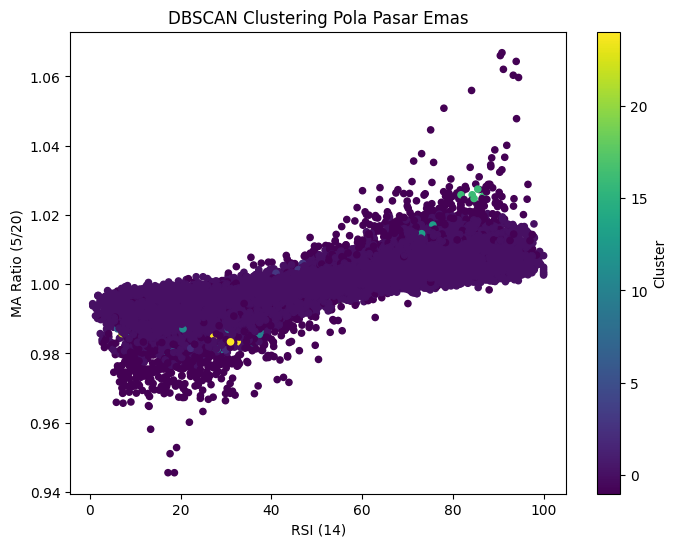

In [ ]:
plt.figure(figsize=(8,6))
plt.scatter(df['rsi_14'], df['ma_ratio'], c=df['cluster'], cmap='viridis', s=20)
plt.xlabel("RSI (14)")
plt.ylabel("MA Ratio (5/20)")
plt.title("DBSCAN Clustering Pola Pasar Emas")
plt.colorbar(label='Cluster')
plt.show()

In [ ]:
# Lihat rata-rata fitur tiap cluster
cluster_summary = df.groupby('cluster')[['return_1h','ma_ratio','rsi_14','volatility','volume_change']].mean()
print(cluster_summary)

         return_1h  ma_ratio     rsi_14  volatility  volume_change
cluster                                                           
-1       -0.000268  0.998448  48.501638    0.011159      12.885006
 0        0.000025  1.000186  51.217306    0.002628       0.160391
 1       -0.002577  0.982462  17.371976    0.007871       0.170022
 2        0.004243  0.981216  24.575097    0.009800      -0.109916
 3       -0.010978  1.003086  45.127677    0.014311       0.515377
 4        0.006595  1.009588  66.389110    0.008244       0.291726
 5        0.007972  1.009131  83.786593    0.009767       0.440536
 6       -0.006056  0.980287  20.423372    0.007785       0.023266
 7       -0.005578  0.986527   9.841193    0.007908       0.367381
 8        0.007007  0.987098  31.562706    0.009225       0.130650
 9        0.006175  0.982353  28.687232    0.010094      -0.134709
 10       0.007872  0.987330  37.285863    0.011905       0.404593
 11      -0.007597  0.988081  26.223259    0.011241       0.11

## Pertanyaan Terpilih
1. Bagaimana rata-rata harga emas per bulan atau per tahun dari 1980 hingga 2025?
2. Apakah terdapat pola musiman (seasonal pattern) pada harga emas dalam rentang waktu tertentu (harian, bulanan, tahunan)?
3. Pada periode waktu apa harga emas menunjukkan fluktuasi (volatilitas) paling tinggi?
4. Mengapa harga emas meningkat tajam pada waktu-waktu tertentu, apakah karena adanya peristiwa ekonomi global seperti inflasi atau kebijakan suku bunga?